# QF605 Fixed Income Securities
## Project Part III
## CMS Convexity Correction
YU Lingfeng

In [226]:
# importing labraries
import numpy as np
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math
from scipy.optimize import brentq, fsolve, least_squares
from scipy.stats import norm
from scipy.integrate import quad
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## <a id = "top">Table of Content</a>
### [Q1. Calibrated SABR to price Constant Maturity Swap (CMS)](#p1)   

- ##### [1.1 PV of a leg receiving CMS10y semi-annually over the next 5 years](#p11)
- ##### [1.2 PV of a leg receiving CMS2y quarterly over the next 10 years](#p12)

### [Q2.  Forward Swap Rates VS CMS rates](#p2)
- ##### [2.1 Rate Surface](#p21)
- ##### [2.2 Discussion on convexity correction](#p22)


## <a id = "p1"> Q1. </a> Calibrated SABR to price CMS [back to table of contents](#top)

In [227]:
beta_fix=0.9

In [228]:
def Black76Call(F, K, sigma, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return F*norm.cdf(d1) - K*norm.cdf(d2)

def Black76Put(F, K, sigma, T):
    d1 = (np .log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*norm.cdf(-d2) - F*norm.cdf(-d1)

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


For static replication of any constant maturity swap (CMS) payoff $g(F)$, where $F$ is the swap rate, we use the following formula:

  \begin{equation*}
    \begin{split}
      V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
      &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
      \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

where

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}
  
For CMS rate payoff, the payoff function can be defined simply as $g(F)=F$, and the static replication formula simplifies into:

  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

We can implement this in Python. First we define the IRR functions.

Let $m$ denote the payment frequenc ($m=2$ for semi-annual payment frequency), and let $N = T_N-T_n$ denote the tenor of the swap (number of years), the partial derivatives on the IRR function $\mbox{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\mbox{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\mbox{IRR}'(K)&=-\frac{1}{K}\mbox{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\mbox{IRR}''(K)&=-\frac{2}{K}\mbox{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}

These results will need to be generalised to handle the case for $m=2$ to be consistent with the semi-annual payment frequency swap market data provided.


In [229]:
### by close form formula
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative =\
        -1/K*IRR_0(K, m, N) +\
        1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative =\
        -2/K*IRR_1(K, m, N) -\
        1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative

In [230]:
### By numeric method
### Lecture 5, Page 5/22

#IRR function 
def IRR_0(x,N,m):
    IRR=np.zeros(N*m)
    IRRS=0
    for i in range(N*m):
        IRR[i]= 1/m / (1+x/m)**i
    IRRS=np.sum(IRR[:])
    return IRRS
# first derivative of IRR
def IRR_1(x,N,m):
    dx = 0.00001 * x
    IRRplus= IRR_0(x+dx,N,m)
    IRRminus = IRR_0(x-dx,N,m)
    IRRf = (IRRplus - IRRminus) / (2*dx)
    return IRRf

# second derivative of IRR
def IRR_2(x,N,m):
    dx = 0.00001 * x
    IRRplus= IRR_0(x+dx,N,m)
    IRRx = IRR_0(x,N,m)
    IRRminus = IRR_0(x-dx,N,m)
    IRRff = (IRRplus - 2*IRRx + IRRminus) / (dx**2)
    return IRRff


In [231]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

In [232]:
def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative =\
        (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) /\
        IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative =\
        ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) -\
          2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 +\
         2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

We will also need to implement the IRR-settled payer and receiver swaption formulae:

  \begin{equation*}
    \begin{split}
      V^{pay}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Call}(S_{n,N}(0),K,\sigma_{n,N},T) \\
      V^{rec}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Put}(S_{n,N}(0),K,\sigma_{n,N},T) \\
    \end{split}
  \end{equation*}

where $S_{n,N}(0)=F$ is today's forward swap rate calculated based on the curves we bootstrapped, and $\sigma_{n,N}$ is the SABR implied volatility calibrated to swaption market data.

In [233]:
# ### Lecture 5, Page 17/22

# receiver payoff convexity part for strike range [0, F]
def I_put(x,m,N,F,sigma,T):
    h = h_2(x, m, N)
    Vrec = Black76Put(F, x, sigma, T)
    return h*Vrec
# payer swaptions convexity part for strike range [F, np.inf]
def I_call(x,m,N,F,sigma,T):
    h = h_2(x, m, N)
    Vpay = Black76Call(F, x, sigma, T)
    return h*Vpay

In [234]:
def int_p3q1(df):
    int_df =\
        df\
        .copy()\
        .astype(float)

    int_df =\
        pd.concat([int_df,
                   pd.DataFrame(2*df.loc[df.index[0]]-\
                                    df.loc[df.index[1]], 
                                columns =\
                                    [2*df.index[0]-df.index[1]]).T],
                  axis=0)\
        .sort_index()
    
    int_df =\
        pd.concat([int_df, 
                   pd.DataFrame(index =\
                                np.arange((2*df.index[0]-\
                                              df.index[1]),
                                          10.1, 
                                          0.25))], 
                  axis = 0)\
        .sort_index()\
        .reset_index()\
        .drop_duplicates(subset='index',
                         keep='first')\
        .set_index('index')\
        .interpolate()    
    return int_df.loc[0:]

In [235]:
fsw =\
    pd.read_csv("###P1 Forward Swap Rate.csv", 
                index_col=[0])
print(fsw.columns)
fsw.columns =\
    [1, 2, 3, 5, 10] 
print(fsw.index)
fsw.index =\
    [1, 5, 10] 
fsw

Index(['X 1y', 'X 2y', 'X 3y', 'X 5y', 'X 10y'], dtype='object')
Index(['1y', '5y', '10y'], dtype='object', name='Expiry/Tenor')


,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [236]:
alpha =\
    pd.read_csv("###P2 SABR Alpha.csv", 
                index_col=[0])
print(alpha.columns)
alpha.columns =\
    [1, 2, 3, 5, 10] 
print(alpha.index)
alpha.index =\
    [1, 5, 10] 
alpha

Index(['1Y', '2Y', '3Y', '5Y', '10Y'], dtype='object')
Index(['1Y', '5Y', '10Y'], dtype='object', name='Swaption SABR Alpha')


,1,2,3,5,10
1,0.139066,0.184646,0.196849,0.178070,0.171053
5,0.166601,0.199524,0.210373,0.191040,0.177010
10,0.177846,0.195667,0.208321,0.202042,0.181077


In [237]:
rho =\
    pd.read_csv("###P2 SABR Rho.csv", 
                index_col=[0])
print(rho.columns)
rho.columns =\
    [1, 2, 3, 5, 10] 
print(rho.index)
rho.index =\
    [1, 5, 10] 
rho

Index(['1Y', '2Y', '3Y', '5Y', '10Y'], dtype='object')
Index(['1Y', '5Y', '10Y'], dtype='object', name='Swaption SABR Rho')


,1,2,3,5,10
1,-0.633247,-0.525117,-0.482843,-0.414470,-0.264432
5,-0.585586,-0.546990,-0.549880,-0.511199,-0.437109
10,-0.546935,-0.545584,-0.553741,-0.563938,-0.511636


In [238]:
nu =\
    pd.read_csv("###P2 SABR Nu.csv", 
                index_col=[0])
print(nu.columns)
nu.columns =\
    [1, 2, 3, 5, 10] 
print(nu.index)
nu.index =\
    [1, 5, 10] 
nu

Index(['1Y', '2Y', '3Y', '5Y', '10Y'], dtype='object')
Index(['1Y', '5Y', '10Y'], dtype='object', name='Swaption SABR Nu')


,1,2,3,5,10
1,2.049561,1.677431,1.438152,1.064775,0.778196
5,1.340313,1.061987,0.936768,0.671637,0.497094
10,1.008553,0.926678,0.871791,0.720039,0.578078


In [239]:
df_all =\
    pd.read_csv("###P1 All DFs.csv", 
                index_col=[0])
df_all.head()

,OIS DF,LIBOR DF
Tenor,,
0.5,0.998752,0.987654
1.0,0.997009,0.972577
1.5,0.995270,0.957378
2.0,0.993531,0.942179
2.5,0.991773,0.926330


##### <a id = "p11"> </a> 1.1  receiving CMS10y semi-annually over the next 5 years [back to table of contents](#top)

In [240]:
q1_alpha =\
    int_p3q1(alpha)
q1_alpha.index.name = 'SABR Alpha'
q1_alpha.head(10)

,1,2,3,5,10
SABR Alpha,,,,,
0.00,0.132183,0.180926,0.193468,0.174827,0.169563
0.25,0.133904,0.181856,0.194313,0.175638,0.169936
0.50,0.135625,0.182786,0.195158,0.176448,0.170308
0.75,0.137345,0.183716,0.196004,0.177259,0.170680
1.00,0.139066,0.184646,0.196849,0.178070,0.171053
1.25,0.140787,0.185575,0.197694,0.178880,0.171425
1.50,0.142508,0.186505,0.198539,0.179691,0.171797
1.75,0.144229,0.187435,0.199385,0.180501,0.172170
2.00,0.145950,0.188365,0.200230,0.181312,0.172542


In [241]:
q1_rho =\
    int_p3q1(rho)
q1_rho.index.name = 'SABR Rho'
q1_rho.head(10)

,1,2,3,5,10
SABR Rho,,,,,
0.00,-0.645163,-0.519648,-0.466084,-0.390287,-0.221263
0.25,-0.642184,-0.521016,-0.470274,-0.396333,-0.232055
0.50,-0.639205,-0.522383,-0.474463,-0.402379,-0.242848
0.75,-0.636226,-0.523750,-0.478653,-0.408424,-0.253640
1.00,-0.633247,-0.525117,-0.482843,-0.414470,-0.264432
1.25,-0.630268,-0.526484,-0.487033,-0.420515,-0.275225
1.50,-0.627290,-0.527851,-0.491223,-0.426561,-0.286017
1.75,-0.624311,-0.529218,-0.495412,-0.432607,-0.296809
2.00,-0.621332,-0.530585,-0.499602,-0.438652,-0.307602


In [242]:
q1_nu =\
    int_p3q1(nu)
q1_nu.index.name = 'SABR Nu'
q1_nu.head(10)

,1,2,3,5,10
SABR Nu,,,,,
0.00,2.226873,1.831292,1.563498,1.163059,0.848472
0.25,2.182545,1.792827,1.532161,1.138488,0.830903
0.50,2.138217,1.754361,1.500825,1.113917,0.813334
0.75,2.093889,1.715896,1.469488,1.089346,0.795765
1.00,2.049561,1.677431,1.438152,1.064775,0.778196
1.25,2.005233,1.638966,1.406815,1.040204,0.760628
1.50,1.960905,1.600500,1.375479,1.015633,0.743059
1.75,1.916577,1.562035,1.344142,0.991061,0.725490
2.00,1.872249,1.523570,1.312806,0.966490,0.707921


In [243]:
df_all

,OIS DF,LIBOR DF
Tenor,,
0.5,0.998752,0.987654
1.0,0.997009,0.972577
1.5,0.995270,0.957378
2.0,0.993531,0.942179
2.5,0.991773,0.926330
3.0,0.990015,0.910482
3.5,0.988066,0.894731
4.0,0.986117,0.878981
4.5,0.984150,0.863985


In [244]:
expiry = np.arange(0.5, 5.5, 0.5)
Tenor = [10]
m = 2

S10y=[]
CMS10y = []
OIS10y = []
alpha10y = []
rho10y = []
nu10y = []
for ex in expiry:
    S_Ts = []
    CMS10y_row = []
    OIS10y_row = []
    alpha10y_row = []
    rho10y_row = []
    nu10y_row = []
    for T in Tenor:
        df_eff =\
            df_all.loc[ex:ex+T]
        fix_part_sum =\
            sum(df_eff.iloc[1:, 0])
        flt_part_sum = 0
        for i in range(1,len(df_eff)):
            flt_part_sum +=\
                df_eff.iloc[i,0] * \
                df_eff.iloc[i-1,1] /\
                df_eff.iloc[i,1]          
        
        S_T =\
            (flt_part_sum - fix_part_sum) /\
            (0.5 * fix_part_sum)
        
        S_Ts += [S_T]


        alpha10y_row +=\
            [q1_alpha.loc[ex, T]]
        rho10y_row =\
            [q1_rho.loc[ex, T]]
        nu10y_row =\
            [q1_nu.loc[ex,T]]  
        
        F = S_T
        N = T

        term1 =\
            quad(lambda x:I_put(x,m,N,F,
                                SABR(F, x, ex, q1_alpha.loc[ex,T], beta_fix, q1_rho.loc[ex,T], q1_nu.loc[ex,T]), 
                                ex),0,F)
        term2 =\
            quad(lambda x:I_call(x,m,N,F,
                                SABR(F, x, ex, q1_alpha.loc[ex,T], beta_fix, q1_rho.loc[ex,T], q1_nu.loc[ex,T]), 
                                ex),F,np.inf)
        
        CMS10y_row += [F*df_all.loc[ex,'OIS DF'] + term1[0] + term2[0]]   

    CMS10y += [CMS10y_row]
    alpha10y += [alpha10y_row]
    rho10y += [rho10y_row]
    nu10y += [nu10y_row]    
    S10y += [S_Ts]
    
CMS10y_semi =\
    pd.DataFrame({'Tenor': Tenor*len(expiry)})

CMS10y_semi =\
    pd.concat([CMS10y_semi,
               pd.DataFrame(S10y,
                            columns=['Forward Swap']), 
               pd.DataFrame(df_all.loc[expiry, 'OIS DF'].values, 
                            columns=['OIS DF']),
               pd.DataFrame(alpha10y,
                            columns=['alpha']),
               pd.DataFrame({'beta': 
                             [beta_fix]*len(expiry)}),
               pd.DataFrame(rho10y,
                            columns=['rho']),
               pd.DataFrame(nu10y,
                            columns=['nu']),
               pd.DataFrame(CMS10y, 
                            columns =['CMS'])], 
              axis =1)

CMS10y_semi.index = expiry
CMS10y_semi.index.name='Semi Annual'
CMS10y_semi.to_csv('###P3 CMS 10yX5y semi.csv')
CMS10y_semi

,Tenor,Forward Swap,OIS DF,alpha,beta,rho,nu,CMS
Semi Annual,,,,,,,,
0.5,10,0.037845,0.998752,0.170308,0.9,-0.242848,0.813334,0.037820
1.0,10,0.038428,0.997009,0.171053,0.9,-0.264432,0.778196,0.038368
1.5,10,0.039020,0.995270,0.171797,0.9,-0.286017,0.743059,0.038952
2.0,10,0.039634,0.993531,0.172542,0.9,-0.307602,0.707921,0.039637
2.5,10,0.040200,0.991773,0.173287,0.9,-0.329186,0.672783,0.040371
3.0,10,0.040788,0.990015,0.174031,0.9,-0.350771,0.637645,0.041172
3.5,10,0.041412,0.988066,0.174776,0.9,-0.372355,0.602508,0.041959
4.0,10,0.042062,0.986117,0.175521,0.9,-0.393940,0.567370,0.042665
4.5,10,0.042831,0.984150,0.176265,0.9,-0.415525,0.532232,0.043363


> ### PV of receiving CMS10y Semi Annually Over The Next 5 Years

In [245]:
PV_CMS10by5_semi =\
    sum(CMS10y_semi['OIS DF'] *\
        CMS10y_semi['CMS'] * 0.5)
print(f"PV of receiving CMS10y Semi Annually\
 Over The Next 5 Years is {PV_CMS10by5_semi}")

PV of receiving CMS10y Semi Annually Over The Next 5 Years is 0.20219261522196158


##### <a id = "p12"> </a> 1.2  receiving CMS2y quarterly over the next 10 years [back to table of contents](#top)

In [246]:
DF_quarter = int_p3q1(df_all)
DF_quarter.index.name = 'DF_quarter'
DF_quarter

,OIS DF,LIBOR DF
DF_quarter,,
0.00,1.000494,1.002732
0.25,0.999623,0.995193
0.50,0.998752,0.987654
0.75,0.997880,0.980116
1.00,0.997009,0.972577
...,...,...
28.00,0.857941,0.260573
28.50,0.855307,0.251346
29.00,0.852674,0.242118


In [247]:
DF_quarter.index

Index([ 0.0, 0.25,  0.5, 0.75,  1.0, 1.25,  1.5, 1.75,  2.0, 2.25,  2.5, 2.75,
        3.0, 3.25,  3.5, 3.75,  4.0, 4.25,  4.5, 4.75,  5.0, 5.25,  5.5, 5.75,
        6.0, 6.25,  6.5, 6.75,  7.0, 7.25,  7.5, 7.75,  8.0, 8.25,  8.5, 8.75,
        9.0, 9.25,  9.5, 9.75, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5,
       14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5,
       20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5,
       26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0],
      dtype='float64', name='DF_quarter')

In [248]:
expiry = np.arange(0.25, 10.1, 0.25)
Tenor = [2]
m = 4

S2y=[]
CMS2y = []
OIS2y = []
alpha2y = []
rho2y = []
nu2y = []
for ex in expiry:
    S_Ts = []
    CMS2y_row = []
    OIS2y_row = []
    alpha2y_row = []
    rho2y_row = []
    nu2y_row = []
    for T in Tenor:
        df_eff =\
            DF_quarter.loc[ex:ex+T]
        fix_part_sum =\
            sum(df_eff.iloc[1:, 0])
        flt_part_sum = 0
        for i in range(1,len(df_eff)):
            flt_part_sum +=\
                df_eff.iloc[i,0] * \
                df_eff.iloc[i-1,1] /\
                df_eff.iloc[i,1]          
        
        S_T =\
            (flt_part_sum - fix_part_sum) /\
            (0.5 * fix_part_sum)
        
        S_Ts += [S_T]


        alpha2y_row +=\
            [q1_alpha.loc[ex, T]]
        rho2y_row =\
            [q1_rho.loc[ex, T]]
        nu2y_row =\
            [q1_nu.loc[ex,T]]  
        
        F = S_T
        N = T

        term1 =\
            quad(lambda x:I_put(x,m,N,F,
                                SABR(F, x, ex, q1_alpha.loc[ex,T], beta_fix, q1_rho.loc[ex,T], q1_nu.loc[ex,T]), 
                                ex),0,F)
        term2 =\
            quad(lambda x:I_call(x,m,N,F,
                                SABR(F, x, ex, q1_alpha.loc[ex,T], beta_fix, q1_rho.loc[ex,T], q1_nu.loc[ex,T]), 
                                ex),F,np.inf)
        
        CMS2y_row += [F*DF_quarter.loc[ex,'OIS DF'] + term1[0] + term2[0]]  

    CMS2y += [CMS2y_row]
    alpha2y += [alpha2y_row]
    rho2y += [rho2y_row]
    nu2y += [nu2y_row]    
    S2y += [S_Ts]
    
CMS2y_quarter =\
    pd.DataFrame({'Tenor': Tenor*len(expiry)})

CMS2y_quarter =\
    pd.concat([CMS2y_quarter,
               pd.DataFrame(S2y,
                            columns=['Forward Swap']), 
               pd.DataFrame(DF_quarter.loc[expiry, 'OIS DF'].values, 
                            columns=['OIS DF']),
               pd.DataFrame(alpha2y,
                            columns=['alpha']),
               pd.DataFrame({'beta': 
                             [beta_fix]*len(expiry)}),
               pd.DataFrame(rho2y,
                            columns=['rho']),
               pd.DataFrame(nu2y,
                            columns=['nu']),
               pd.DataFrame(CMS2y, 
                            columns =['CMS'])], 
              axis =1)

CMS2y_quarter.index = expiry
CMS2y_quarter.index.name='Quarterly'
CMS2y_quarter.to_csv('###P3 CMS 2yX10y quarter.csv')
CMS2y_quarter

,Tenor,Forward Swap,OIS DF,alpha,beta,rho,nu,CMS
Quarterly,,,,,,,,
0.25,2,0.015859,0.999623,0.181856,0.9,-0.521016,1.792827,0.015855
0.50,2,0.016089,0.998752,0.182786,0.9,-0.522383,1.754361,0.016081
0.75,2,0.016323,0.997880,0.183716,0.9,-0.523750,1.715896,0.016378
1.00,2,0.016561,0.997009,0.184646,0.9,-0.525117,1.677431,0.016865
1.25,2,0.016773,0.996139,0.185575,0.9,-0.526484,1.638966,0.017566
1.50,2,0.016990,0.995270,0.186505,0.9,-0.527851,1.600500,0.018475
1.75,2,0.017156,0.994400,0.187435,0.9,-0.529218,1.562035,0.019459
2.00,2,0.017325,0.993531,0.188365,0.9,-0.530585,1.523570,0.020494
2.25,2,0.017409,0.992652,0.189295,0.9,-0.531952,1.485105,0.021415


> ### PV of CMS2y Quarterly Over The Next 10 Years

In [249]:
PV_CMS2by10_quarter =\
    sum(CMS2y_quarter['OIS DF'] *\
        CMS2y_quarter['CMS'] * 0.25)
print(f"PV of receiving CMS2y Quarterly\
 Over The Next 10 Years is {PV_CMS2by10_quarter}")

PV of receiving CMS2y Quarterly Over The Next 10 Years is 0.29857772486114625


## <a id = "p2"> Q2. </a>  Forward Swap Rates VS CMS rates [back to table of contents](#top)

In [250]:
fsw

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


##### <a id = "p21"> </a> 2.1  Rate Surface [back to table of contents](#top)

In [251]:
# use CMS replication payoff function to calculate the CMS rate
# semi annually payment frequency
Expiry = [1, 5, 10]
Tenor = [1, 2, 3, 5, 10]
CMS = []
for ex in Expiry:
    CMS_row = []
    for T in Tenor:       
        # N is the number of the swap tenor
        fsr = fsw.loc[ex, T]
        F = fsr
        N = T
        term1 =\
            quad(lambda x:I_put(x,m,N,F,
                                SABR(F, x, ex, q1_alpha.loc[ex,T], beta_fix, q1_rho.loc[ex,T], q1_nu.loc[ex,T]), 
                                ex),0,F)
        term2 =\
            quad(lambda x:I_call(x,m,N,F,
                                SABR(F, x, ex, q1_alpha.loc[ex,T], beta_fix, q1_rho.loc[ex,T], q1_nu.loc[ex,T]), 
                                ex),F,np.inf)
        
        CMS_row += [F*df_all.loc[ex,'OIS DF'] + term1[0] + term2[0]]  
        

    CMS += [CMS_row]
    
CMS =\
    pd.DataFrame(CMS, 
                 index = Expiry, 
                 columns = Tenor)
CMS.index.name = 'CMS Rates Table'
CMS.to_csv('###P3 CMS Rate Table.csv')
CMS

,1,2,3,5,10
CMS Rates Table,,,,,
1,0.032293,0.033815,0.034331,0.035233,0.038372
5,0.047348,0.051875,0.051165,0.044023,0.044069
10,0.054745,0.072148,0.084586,0.081915,0.094955


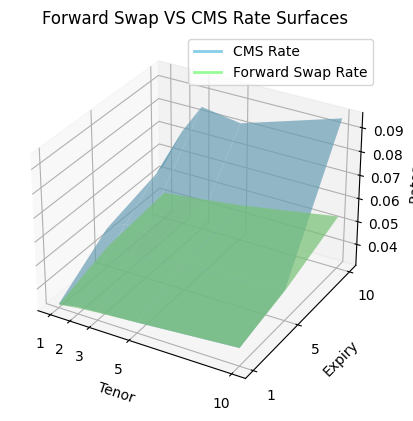

In [252]:
x = Tenor
y = Expiry
X, Y = np.meshgrid(x, y)

Z1 = fsw.values
Z2 = CMS.values  

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the first surface
surf1 = ax.plot_surface(X, Y, Z1,
                        color='palegreen',
                        alpha=0.7, 
                        label='Forward Swap Rate')

# Plot the second surface
surf2 = ax.plot_surface(X, Y, Z2,
                        color='skyblue', 
                        alpha=0.7, 
                        label='CMS Rate')

# Customize the plot (optional)
# Set specific ticks for X-axis
ax.set_xticks(Tenor)
ax.set_xlabel('Tenor')
ax.set_yticks(Expiry)
ax.set_ylabel('Expiry')
ax.set_zlabel('Rates')
ax.set_title('Forward Swap VS CMS Rate Surfaces')

# Create Line2D objects for the legend
legend_elements =\
    [Line2D([0], [0], color='skyblue', lw=2, label='CMS Rate'),
     Line2D([0], [0], color='palegreen', lw=2, label='Forward Swap Rate')]

# Add legend
ax.legend(handles=legend_elements)
plt.savefig('P3_CMSvsForwardSwap.png')
# Show the plot
plt.show()


##### <a id = "p22"> </a> 2.2  Discussion on convexity correction [back to table of contents](#top)

In [253]:
Rate_difference = CMS-fsw
Rate_difference.index.name =\
    'CMS - Forward Swap'
Rate_difference.to_csv('###P3 CMS-ForwardSwap.csv')
Rate_difference

,1,2,3,5,10
CMS - Forward Swap,,,,,
1,0.000286,0.000555,0.000321,-0.000023,-0.000056
5,0.008074,0.011800,0.011093,0.002930,0.000435
10,0.012556,0.029032,0.040489,0.035666,0.041497


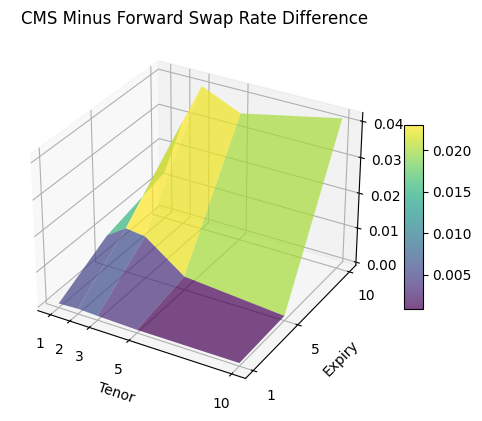

In [254]:
x = Tenor
y = Expiry
X, Y = np.meshgrid(x, y)

Z1 = fsw.values
Z2 = CMS.values  

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the first surface
surf1 = ax.plot_surface(X, Y, Z2-Z1, 
                        cmap='viridis', 
                        alpha=0.7, 
                        label='Difference')

# Set specific ticks for X-axis
ax.set_xticks(Tenor)
ax.set_xlabel('Tenor')
ax.set_yticks(Expiry)
ax.set_ylabel('Expiry')
ax.set_zlabel('Rate Difference')
ax.set_title('CMS Minus Forward Swap Rate Difference')

# Add a colorbar to show the correspondence between colors and values
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10)
plt.savefig('P3_CMS-ForwardSwap.png')
# Show the plot
plt.show()

The observations are as follows:
* There is minor difference between the CMS rate and forward swap rate. This is because the CMS is valued at a wrong time. The CMS rate you receive at time $T_{i+1}$ is the par swap rate in the market at $T_{i}$. 
* if we were using the forward rate to value CMS product, we need some convexity corrections to calibrate the price of CMS.
* From the comparison table we have above, we can see that the longer the tenor, the higher the difference between the CMS rate product and forward rate. This may be due to the longer the tenor, we need more swaptions to do convexity corrections, which will cause higher trancation errors during the whole process, leading to a higher difference between the CMS and forward rate 
* Increase in either Tenor, or Expiry would result in larger rate differece.